In [31]:
# Lichess-Dataset-Exploration-Visualisation

#import des modules nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [47]:
#1/ Chargement des données
games = pd.read_csv("games.csv")
#2/ Vérification des données
games.isna().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

In [33]:
elo_w = games['white_rating']
elo_b = games['black_rating']
elo = np.hstack((elo_w,elo_b))
# Caclul du nombre total de joueurs différents
id_players = np.hstack((np.array(games['black_id']),np.array(games['white_id'])))
id_player = np.unique(id_players)

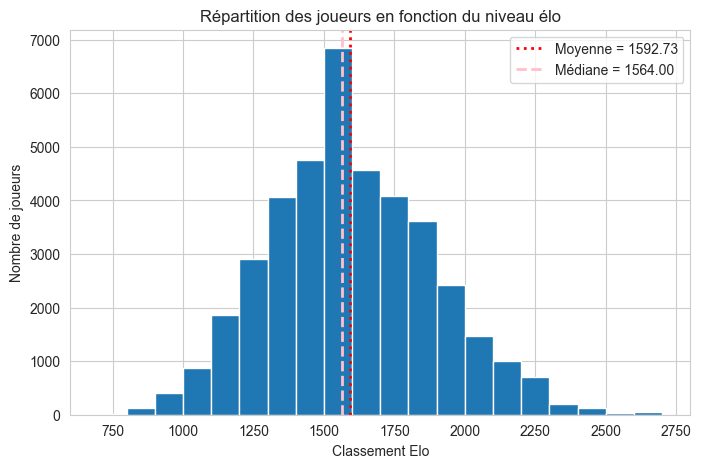

,Statistique,Valeur
0,Nombre total de parties,20058.00
1,Nombre total de joueurs différents,15635.00
2,Moyenne du classement Elo,1592.73
3,Médiane du classement Elo,1564.00
4,Classement Elo maximum,2723.00
5,Classement Elo minimum,784.00
6,Pourcentage de joueurs entre 1400 et 1600 élo,58.15
7,Pourcentage de joueurs à exactemet 1500 élo,8.02


In [34]:
# Visualisation des données sous la forme de graphiques
moyenne = np.round(np.mean(elo),2);
mediane = np.round(np.median(elo),2);

#Tracé
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
plt.hist(elo,bins=range(700,2800,100))
plt.title("Répartition des joueurs en fonction du niveau élo");
plt.xlabel("Classement Elo");
plt.ylabel("Nombre de joueurs");
plt.axvline(moyenne, color='red', linestyle='dotted', linewidth=2, label=f"Moyenne = {moyenne:.2f}")
plt.axvline(mediane, color='pink', linestyle='dashed', linewidth=2, label=f"Médiane = {mediane:.2f}")
plt.legend()
plt.show()

# DataFrame de synthèse
summary_data = {
    "Statistique": [
        "Nombre total de parties",
        "Nombre total de joueurs différents",
        "Moyenne du classement Elo",
        "Médiane du classement Elo",
        "Classement Elo maximum",
        "Classement Elo minimum",
        "Pourcentage de joueurs entre 1400 et 1600 élo",
        "Pourcentage de joueurs à exactemet 1500 élo"
    ],
    "Valeur": [
        games.shape[0],
        id_player.size,
        round(moyenne, 2),
        round(mediane, 2),
        np.max(elo),
        np.min(elo),
        np.round(np.size(elo[(elo>=1400)&(elo<=1600)])/games.shape[0]*100,2),
        np.round(np.size(elo[(elo==1500)])/games.shape[0]*100,2)
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)


,Statistique,Valeur
0,Nb. victoires blancs,10001
1,Nb. victoires noirs,9107
2,Nb. match nul,950


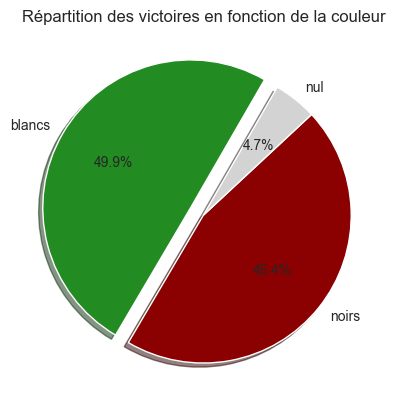

In [35]:
# Visualisation de la répartition des résultats des parties en fonction de la couleur

w_white = games[games['winner'] == 'white'].shape[0]
w_black = games[games['winner'] == 'black'].shape[0]
draw = games[games['winner']=='draw'].shape[0]
labels = 'blancs','noirs','nul'
fig, ax = plt.subplots()
ax.pie([w_white,w_black,draw],explode=(0.1, 0, 0), labels=labels, autopct='%1.1f%%',colors=['forestgreen','darkred','lightgrey'],shadow=True, startangle=60)
plt.title("Répartition des victoires en fonction de la couleur");

# DataFrame de synthèse

summary_data = {
    "Statistique": [
        "Nb. victoires blancs",
        "Nb. victoires noirs",
        "Nb. match nul"
    ],
    "Valeur": [
        w_white,
        w_black,
        draw
    ]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df)

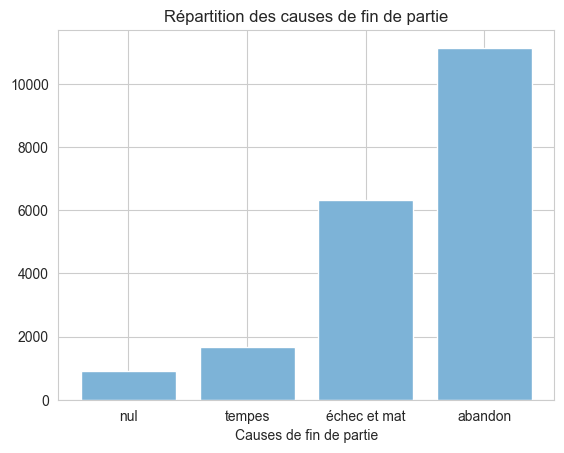

,Statistique,Nombre,Valeur (en %)
0,Nb. de matchs nuls,906,4.52
1,Nb. de victoires au temps,1680,8.38
2,Nb. d'échec et mat,6325,31.53
3,Nb. d'abandon,11147,55.57


In [36]:
# Visualisation des causes de fin de partie
resign = games[games['victory_status']== 'resign'].shape[0]
mate = games[games['victory_status']== 'mate'].shape[0]
time = games[games['victory_status']== 'outoftime'].shape[0]
draw = games[games['victory_status']== 'draw'].shape[0]
total = resign + mate + time + draw

x = ['nul','tempes','échec et mat','abandon']
y = [draw, time, mate, resign]

#Tracé
sns.set_style("whitegrid")
fig, ax = plt.subplots()
colors = sns.color_palette("Blues_d", n_colors=len(x))
for i in range(len(x)):
    ax.bar(x[i], y[i], color=colors)

# Configuration des axes
ax.set_xlabel("Causes de fin de partie")
ax.set_title("Répartition des causes de fin de partie")
plt.show()

# DataFrame de synthèse
summary_data = {
    "Statistique": [
        "Nb. de matchs nuls",
        "Nb. de victoires au temps",
        "Nb. d'échec et mat",
        "Nb. d'abandon"
    ],
    "Nombre": [
        draw,
        time,
        mate,
        resign
    ],
    "Valeur (en %)": [
        np.round((draw/total*100),2),
        np.round((time/total*100),2),
        np.round((mate/total*100),2),
        np.round((resign/total*100),2)
    ]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df)

In [37]:
# Dans cette partie, on s’intéresse à la relation entre la différence de classement Elo 
# entre deux joueurs et le résultat de la partie.
#
# L’objectif est de voir si le joueur ayant le meilleur classement gagne effectivement 
# plus souvent, et dans quelle mesure cela correspond à la théorie du système Elo.
#
# Pour cela, nous allons représenter sous forme de diagrammes circulaires la répartition 
# des victoires selon différents écarts d’Elo.

In [38]:
# Déterminer le joueur le mieux classé
games['diff_elo'] = games['white_rating'] - games['black_rating']

In [41]:
# Définition de la fonction pour analyser la répartition des victoires en fonction de l'écart d'élo
def analyser_ecart_elo(games, elo_min, elo_max):
    filt = games[((np.abs(games["diff_elo"])).between(elo_min,elo_max))]
    nb_total = filt.shape[0]
    elo_sup = filt[(filt['winner']=='white')&(filt['diff_elo']>0)].shape[0] + filt[(filt['winner']=='black')&(filt['diff_elo']<0)].shape[0]
    elo_inf = filt[(filt['winner']=='black')&(filt['diff_elo']>0)].shape[0] + filt[(filt['winner']=='white')&(filt['diff_elo']<0)].shape[0]
    draw = nb_total - elo_sup - elo_inf
    elo_sup += draw/2
    elo_inf += draw/2
    
    labels3 = 'élo supérieur','élo inférieur'
    fig, ax = plt.subplots()
    ax.pie([elo_sup,elo_inf], labels=labels3, autopct='%1.1f%%',shadow=True,explode=(0.1,0),colors=['forestgreen','darkred'])
    plt.title(f"Répartition pour un écart d'Élo entre {elo_min} et {elo_max}");
    
    # DataFrame de synthèse
    
    summary_data = {
        "Statistique": [
            "Victoires du joueur d'élo supérieur",
            "Victoires du joueur d'élo inférieur",
            "Nombre total de parties"
        ],
        "Valeur": [
            elo_sup,
            elo_inf,
            nb_total
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)
    plt.title(f"Répartition pour un écart d'Élo entre {elo_min} et {elo_max}")
    plt.show()
    return 

,Statistique,Valeur
0,Victoires du joueur d'élo supérieur,2817.0
1,Victoires du joueur d'élo inférieur,2657.0
2,Nombre total de parties,5474.0


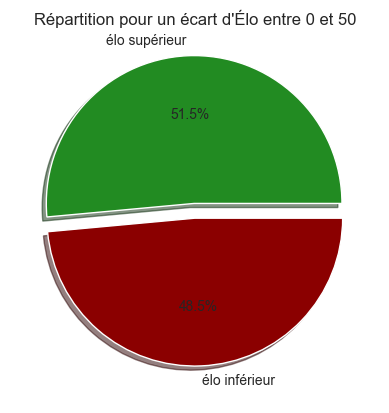

In [42]:
#écart d'élo 1 (En comptant les matchs nuls comme 1/2 victoire)

analyser_ecart_elo(games,0,50)

,Statistique,Valeur
0,Victoires du joueur d'élo supérieur,2187.5
1,Victoires du joueur d'élo inférieur,1591.5
2,Nombre total de parties,3779.0


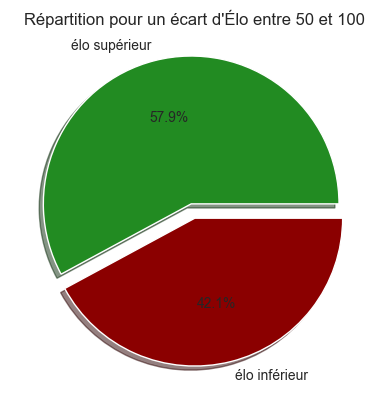

In [43]:
#écart d'élo 2 (En comptant les matchs nuls comme 1/2 victoire) 

analyser_ecart_elo(games,50,100)

,Statistique,Valeur
0,Victoires du joueur d'élo supérieur,2994.5
1,Victoires du joueur d'élo inférieur,1634.5
2,Nombre total de parties,4629.0


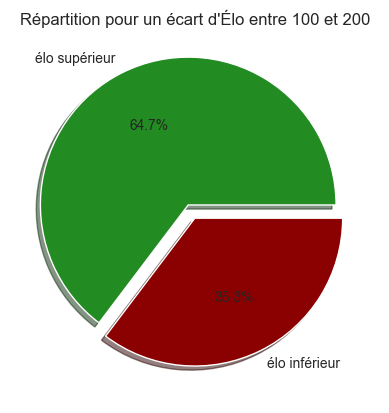

In [44]:
#écart d'élo 3 (En comptant les matchs nuls comme 1/2 victoire)

analyser_ecart_elo(games,100,200)

In [45]:
# Première approche de la régression logistique
#
# Dans cette dernière section, j’applique pour la première fois une régression logistique
# afin d’étudier la relation entre l’écart d’Elo et la probabilité de victoire
# du joueur le mieux classé.
#
# L’objectif ici est avant tout exploratoire et statistique : il s’agit de voir
# si un modèle simple permet de retrouver la tendance générale attendue.
#
# Cette partie n’a donc pas une visée prédictive avancée, mais plutôt un but
# d’apprentissage et de compréhension des méthodes statistiques de base.

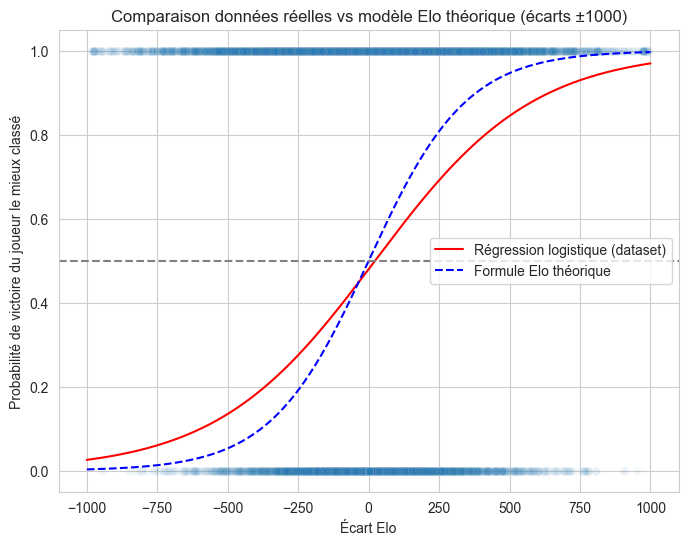

In [46]:
# Déterminer le joueur le mieux classé et s'il a gagné
games["stronger_wins"] = (
    ((games["diff_elo"] > 0) & (games["winner"] == "white")) |
    ((games["diff_elo"] < 0) & (games["winner"] == "black"))
).astype(int)
# Filtrer sur un écart d'élo de [-1000, 1000]
filtered = games[(games["diff_elo"].between(-1000, 1000))].dropna(subset=["stronger_wins"])

X = np.abs(filtered["diff_elo"]).values.reshape(-1, 1)
y = filtered["stronger_wins"].values

#Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Régression logistique
log_reg = LogisticRegression()
log_reg.fit(X_scaled, y)

#Courbe prédictive
x_vals = np.linspace(-1000, 1000, 1000).reshape(-1, 1)
x_vals_scaled = scaler.transform(x_vals)
y_pred = log_reg.predict_proba(x_vals_scaled)[:, 1]

#Tracé
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.scatterplot(x="diff_elo", y="stronger_wins", data=filtered, alpha=0.05)
plt.plot(x_vals, y_pred, color="red", label="Régression logistique (dataset)")

# Ajout du modèle Elo théorique pour comparaison
c = 400 / np.log(10)
elo_model = 1 / (1 + np.exp(-x_vals / c))
plt.plot(x_vals, elo_model, "b--", label="Formule Elo théorique")

plt.axhline(0.5, color="grey", linestyle="--")
plt.xlabel("Écart Elo")
plt.ylabel("Probabilité de victoire du joueur le mieux classé")
plt.title("Comparaison données réelles vs modèle Elo théorique (écarts ±1000)")
plt.legend()
plt.show()